In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
from numpy import linalg as LA
from scipy.spatial import distance
import math

def get_laplacians(x, n_agents, rr, ro, ra, n_neighbors):
    A_r = np.zeros((n_agents, n_agents))
    D_r = np.zeros((n_agents, n_agents))
    A_o = np.zeros((n_agents, n_agents))
    D_o = np.zeros((n_agents, n_agents))
    A_a = np.zeros((n_agents, n_agents))
    D_a = np.zeros((n_agents, n_agents))
    
    if metric == "dist":
        for i in range(n_agents):
            for j in range(n_agents):
                if i == j:
                    continue
                dist = np.sum((x[j] - x[i]) ** 2) ** 0.5
                if dist < rr:
                    A_r[i, j] = 1
                    D_r[i, i] += 1
                elif dist < ro:
                    A_o[i, j] = 1
                    D_o[i, i] += 1
                elif dist < ra:
                    A_a[i, j] = 1
                    D_a[i, i] += 1
    return D_r, A_r, D_o, A_o, D_a, A_a

def get_fiedler_ev(mtx):
    eig_vals = LA.eigvals(mtx)
    eig_vals = np.sort(eig_vals)
    non_zero = eig_vals[eig_vals>1e-10]
    if len(non_zero)==0:
        return 0
    else:
        #print(non_zero[0], eig_vals[1])
        return non_zero[0]

def is_visible(x, x_angles, point_idx, nn_idx, fop):
    # Get direction of neighbor in relation to point
    v = (x[nn_idx] - x[point_idx]) / LA.norm(x[nn_idx] - x[point_idx])
    # Get angle between neighbor direction and point orientation
    angle = np.arccos(np.dot(x_angles[point_idx], v) /
                          (np.linalg.norm(x_angles[point_idx]) * np.linalg.norm(v)))
    
    w = angle <= (fop / 2.0)
    # Check if agent can see this angle
#     assert t == w
#     direction_of_neighbor = x[nn_idx]-x[point_idx]
#     angle2 = get_angle(x_angles[point_idx], direction_of_neighbor) # angle between agents
#     t= abs(angle2) <= (fop / 2.0)

    if w:
        return True
    else:
        return False
    
def target_angles(x, x_angles, r_r, r_o, r_a, fop, mediator=False):
    D = distance.squareform(distance.pdist(x))
    sorted_idx = np.argsort(D, axis=1)
    target_angles = np.copy(x_angles)
    # Each node now has a list of its neighbors sorted by distance
    for point_idx in range(x.shape[0]):
        nn = 1
        dist = 0
        no_repulsors, orient, attractors = True,False,False
        target_angle = np.zeros((x.shape[1]))
        has_neighbors = False
        # Iterate over neighbors until they are out of perception range (farther than ZOA reaches)
        
        # Put mediator in the middle
        if mediator and np.linalg.norm(x[point_idx])<20:
            target_angle = x[point_idx]*1
            attractors = True
        #print("next")

        if True:
            while True:
                if nn == sorted_idx.shape[0]: # no more neighbors
                    break

                nn_idx = sorted_idx[point_idx, nn]
                dist = D[point_idx, nn_idx]

                if is_visible(x, x_angles, point_idx, nn_idx, fop) and dist < r_a:
                    if dist < r_r:
                        no_repulsors = False
                        target_angle -= (x[nn_idx] - x[point_idx]) / LA.norm(x[nn_idx] - x[point_idx])
                    # Neighbors in ZOO and ZOA only take effect if there is no one in the zone of repulsion
                    elif dist < r_o and no_repulsors:
                        orient = True
                        target_angle += x_angles[nn_idx] / LA.norm(x_angles[nn_idx])
                    elif dist < r_a and no_repulsors:
                        attractors = True
                        target_angle += (x[nn_idx] - x[point_idx]) / LA.norm(x[nn_idx] - x[point_idx]) 
                    else: # either all repulsors found, or no other visible people found
                        break
                nn += 1
        if not no_repulsors:
            target_angles[point_idx] = target_angle
        elif orient and attractors:
            # if there are neighbors in both attraction radius and orientation radius, 
            # take average between the two
            target_angles[point_idx] = target_angle / 2
        elif orient or attractors:
            target_angles[point_idx] = target_angle
        #print(no_repulsors, orient, attractors)
    return target_angles


def get_angle(vector1=None,vector2=None):
    if vector1 is None:
        vector1 = np.asarray([1,0])
    sign = np.sign(np.cross(vector1, vector2))
    angle = sign*np.arccos(np.dot(vector1, vector2) /
                          (np.linalg.norm(vector1) * np.linalg.norm(vector2)+1e-6))
    if angle==0 and (np.sign(vector1)!=np.sign(vector2)).any():
        angle=math.pi
    return angle

def unit_vector(vector):
    return vector/LA.norm(vector)

def rotate(x_angles, t_angles, turning_rate, tau=.1, sigma=.2):
    # Turning rate: turning rate * tau (timestep) - can we scale this to be from 0 to 1?
    tau_turning_rate = tau * turning_rate

    for i in range(x_angles.shape[0]):

        # angle from direction to target direction -pi to pi
        angle = get_angle(x_angles[i], t_angles[i])

        # if vectors are completely opposite
        if abs(angle)<1e-6 and (np.sign(x_angles[i]) != np.sign(t_angles[i])).any():
            angle=math.pi

        if abs(angle) <= tau_turning_rate:
            x_angles[i] = t_angles[i]
        elif abs(angle) > tau_turning_rate:
            old_angle =get_angle(None,x_angles[i])
            c = min(1,tau_turning_rate/abs(angle))
            t = old_angle+angle*c
            new_vector = math.cos(t), math.sin(t)
            x_angles[i]=new_vector

    error = np.random.randn(x_angles.shape[0],x_angles.shape[1]) * sigma
    return x_angles + error

def move_agents(x, x_angles, velocity, tau):
    x += x_angles * velocity * tau
    return x

In [2]:
%matplotlib notebook
n_agents = 50
world_dim = 100
M = world_dim / 4
n_neighbors = 5
metric = "nn" # "dist","nn"
n_timesteps = 10000
turning_rate = (50 / 360.0) * 2 * math.pi # 100 degrees to radians. Is tune-able
fop = (225 / 360.0) * 2 * math.pi # 270 degrees field of perception
velocity = 1
tau = 0.1
r_r = 1
r_o = r_r * 2
r_a = r_r * 15
fiedler_r = []
avg_deg_r = []
fiedler_a = []
avg_deg_a = []
fiedler_o = []
avg_deg_o = []
fiedler_COMBINED = []
def plot(n_agents=4, world_dim=100, M=world_dim/4,n_neighbors=5,metric="nn",n_timesteps=10000,turning_rate = (50 / 360.0) * 2 * math.pi, fop = (225 / 360.0) * 2 * math.pi, velocity = 1, tau = 0.1, r_r = 1, r_o=3, r_a=9, contrived=False, arrows=True, mediator=False, direction_arrows=False, force_torus=True, wrap_around=True, sigma=.2):
    global fiedler_r, fiedler_a, fiedler_o, fiedler_COMBINED
    global avg_deg_r, avg_deg_a, avg_deg_o
    x = 2 * M * (np.random.random((n_agents, 2)) - 0.5)
    x_angles = np.random.random((n_agents, 2))-.5
    x_angles = x_angles / LA.norm(x_angles, axis=1)[:,None] # direction vectors are unit vectors
    
    if force_torus: # rotate 90 degrees
        x_angles = np.c_[-x[:,1],x[:,0]]
            
    plot = True
    fiedler_r = []
    avg_deg_r = []
    fiedler_a = []
    avg_deg_a = []
    fiedler_o = []
    avg_deg_o = []
    fiedler_COMBINED = []
    if contrived:
        x = np.asarray([[-3.0,0],[3.0,0],[-4.0,0],[4.0,0]])
        x_angles =  unit_vector(np.asarray([[1.0,0],[-1.1,0],[1.0,0],[-1.1,0]]))
        n_agents=x.shape[0]

    
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.show()

    #target_angles(x, x_angles, r_r, r_o, r_a, fop)

    t_angles = None
    for step in range(n_timesteps):
        ax.clear()
        ax.scatter(x[:,0], x[:,1])
        if arrows:
            if direction_arrows:
                for n in range(n_agents):
                    ax.arrow(x[n,0],x[n,1],x_angles[n,0],x_angles[n,1], width=.25)
            # Target
            if t_angles is not None:
                for n in range(n_agents):
                    ax.arrow(x[n,0],x[n,1],t_angles[n,0],t_angles[n,1], width=.25, color="Blue")
        ax.set_xlim((-world_dim / 2,world_dim / 2))
        ax.set_ylim((-world_dim / 2,world_dim / 2))
        fig.canvas.draw()

        D_r, A_r, D_o, A_o, D_a, A_a = get_laplacians(x, n_agents, r_r, r_o, r_a, n_neighbors)
        t_angles = target_angles(x, x_angles, r_r, r_o, r_a, fop, mediator=mediator)
        t_angles = t_angles / LA.norm(t_angles, axis=1)[:,None]
        x_angles = rotate(x_angles, t_angles, turning_rate, tau, sigma=sigma)
        x_angles = x_angles / LA.norm(x_angles, axis=1)[:,None]
        x = move_agents(x, x_angles, velocity, tau)
        if wrap_around:
            x = (x+2*M)%(4*M)-2*M # wrap agents around
        
        L_r = D_r - A_r
        L_o = D_o - A_o
        L_a = D_a - A_a
        fiedler_r.append(get_fiedler_ev(L_r))
        fiedler_o.append(get_fiedler_ev(L_o))
        fiedler_a.append(get_fiedler_ev(L_a))
        fiedler_COMBINED.append(get_fiedler_ev(L_a+L_o+L_r))
        assert ((L_r<0) != (L_a<0)).any()
        assert ((L_o<0) != (L_a<0)).any()
        
        avg_deg_r.append(np.mean(D_r.diagonal()))
        avg_deg_o.append(np.mean(D_o.diagonal()))
        avg_deg_a.append(np.mean(D_a.diagonal()))

        plt.pause(.02)

    print("Done")

def plot_evs(fiedler_r, fiedler_o, fiedler_a, avg_deg_r, avg_deg_o, avg_deg_a, combined=[]):
    %matplotlib inline
    
    fig = plt.figure()
    ax = fig.add_subplot(2,4,1)
    ax.plot(fiedler_r)
    ax.set_title("Fiedler EV of Repulsion Laplacian")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Fiedler EV of L_r")
    
    fig = plt.figure()
    ax = fig.add_subplot(2,4,2)
    ax.plot(fiedler_o)
    ax.set_title("Fiedler EV of Orientation Laplacian")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Fiedler EV of L_o")

    fig = plt.figure()
    ax = fig.add_subplot(2,4,3)
    ax.plot(fiedler_a)
    ax.set_title("Fiedler EV of Attraction Laplacian")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Fiedler EV of L_a")
  
#     fig = plt.figure()
#     ax = fig.add_subplot(2,4,4)
#     ax.plot(avg_deg_r)
#     ax.set_title("Average Degree of Repulsion Matrix")
#     ax.set_xlabel("Timestep")
#     ax.set_ylabel("Avg Degree of D_r")
    
#     fig = plt.figure()
#     ax = fig.add_subplot(2,4,5)
#     ax.plot(avg_deg_o)
#     ax.set_title("Average Degree of Orientation Matrix")
#     ax.set_xlabel("Timestep")
#     ax.set_ylabel("Avg Degree of D_o")

#     fig = plt.figure()
#     ax = fig.add_subplot(2,4,6)
#     ax.plot(avg_deg_a)
#     ax.set_title("Average Degree of Attraction Matrix")
#     ax.set_xlabel("Timestep")
#     ax.set_ylabel("Avg Degree of D_a")
#     plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(2,4,7)
    ax.plot(combined)
    ax.set_title("Fiedler Combined")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Fiedler EV")


<IPython.core.display.Javascript object>


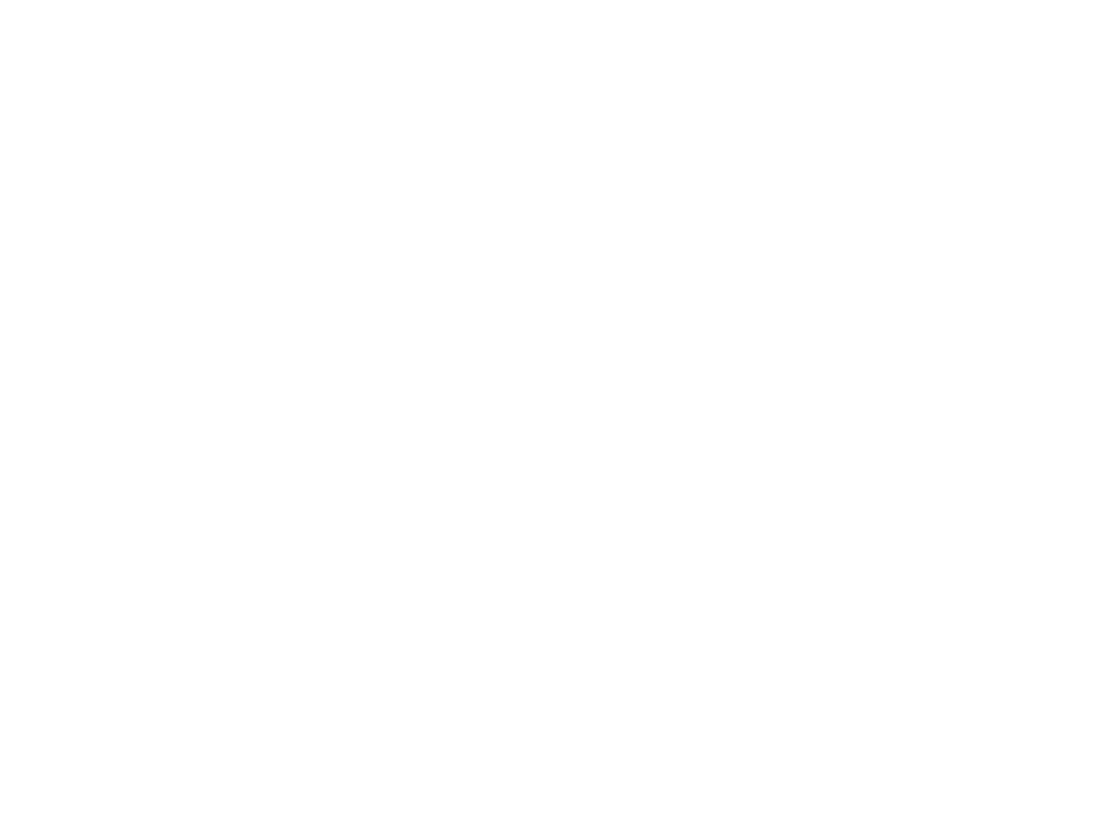

Done


In [3]:
%matplotlib notebook
n_agents = 50
world_dim = 20
M = world_dim / 4
n_neighbors = 5
metric = "dist" # "dist","nn"
n_timesteps = 0
turning_rate = (50 / 360.0) * 2 * math.pi # 100 degrees to radians. Is tune-able
turning_rate = 2/9*math.pi
fop = (225 / 360.0) * 2 * math.pi # 270 degrees field of perception
fop = math.pi*1.1
velocity = 1
tau = 0.02
r_r = 1
r_o = r_r * 1.5
r_a = r_r * 15

plot(n_agents, world_dim, M,n_neighbors,metric,n_timesteps,turning_rate, fop, velocity,tau, r_r,r_o,r_a, contrived=True, arrows=True)

Text(0,0.5,'Avg Degree of D_a')

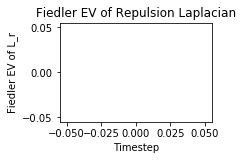

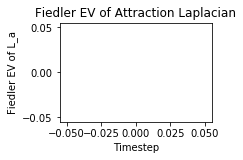

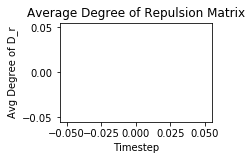

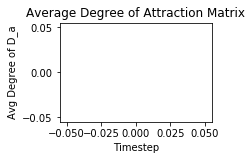

In [4]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.plot(fiedler_r)
ax.set_title("Fiedler EV of Repulsion Laplacian")
ax.set_xlabel("Timestep")
ax.set_ylabel("Fiedler EV of L_r")

fig = plt.figure()
ax = fig.add_subplot(2,2,2)
ax.plot(fiedler_a)
ax.set_title("Fiedler EV of Attraction Laplacian")
ax.set_xlabel("Timestep")
ax.set_ylabel("Fiedler EV of L_a")

fig = plt.figure()
ax = fig.add_subplot(2,2,3)
ax.plot(avg_deg_r)
ax.set_title("Average Degree of Repulsion Matrix")
ax.set_xlabel("Timestep")
ax.set_ylabel("Avg Degree of D_r")

fig = plt.figure()
ax = fig.add_subplot(2,2,4)
ax.plot(avg_deg_a)
ax.set_title("Average Degree of Attraction Matrix")
ax.set_xlabel("Timestep")
ax.set_ylabel("Avg Degree of D_a")

<IPython.core.display.Javascript object>


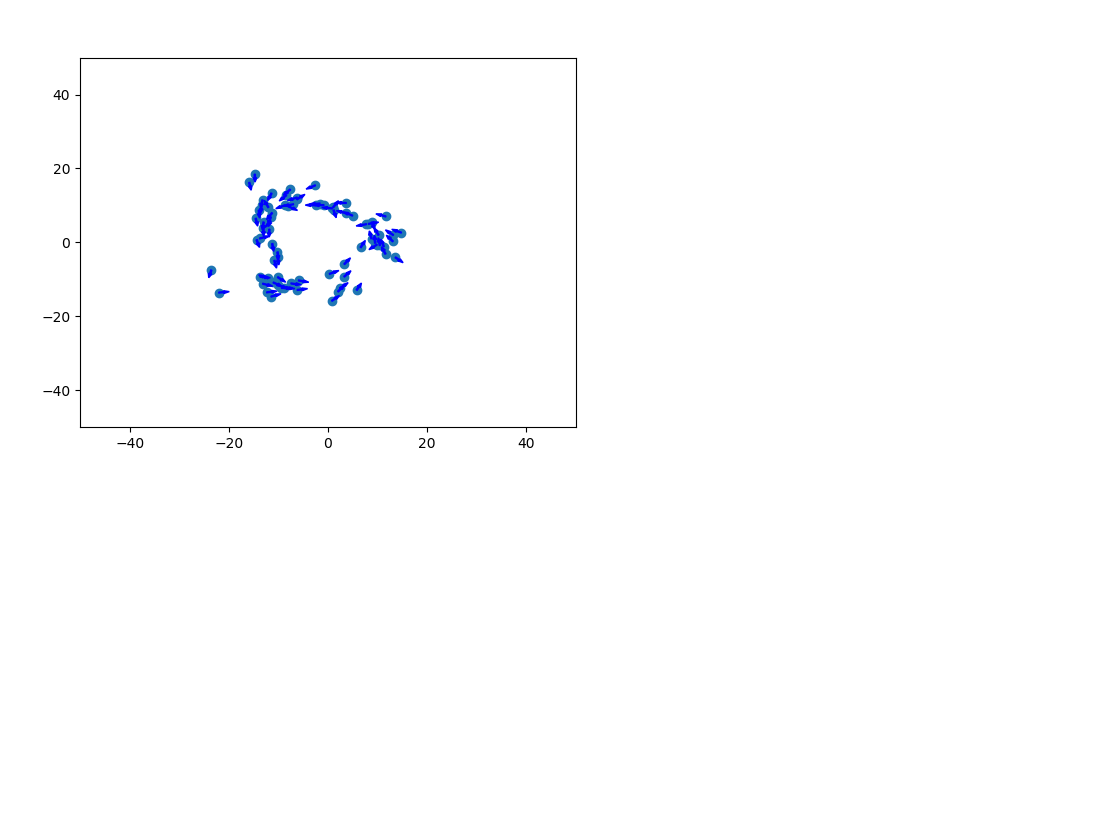

C:\Users\Taylor\AppData\Local\conda\conda\envs\Team\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in arccos


Done


In [5]:
## Torus

%matplotlib notebook
n_agents = 80
world_dim = 100
M = world_dim / 4
n_neighbors = 5
metric = "dist" # "dist","nn"
n_timesteps = 200
turning_rate = (50 / 360.0) * 2 * math.pi # 100 degrees to radians. Is tune-able
turning_rate = 2/9*math.pi
#turning_rate = math.pi*.5

fop = (225 / 360.0) * 2 * math.pi # 270 degrees field of perception
fop = math.pi
velocity = 6
tau = 0.3
r_r = 1
r_o = r_r * 1.6
r_a = r_r * 18
MEDIATOR=False
FORCE_TORUS=True
if FORCE_TORUS:
    turning_rate=1.5/9 * math.pi
SIGMA=0
plot(n_agents, world_dim, M,n_neighbors,metric,n_timesteps,turning_rate, fop, velocity,tau, r_r,r_o,r_a, contrived=False, arrows=True, mediator=MEDIATOR, force_torus=FORCE_TORUS, sigma=SIGMA, wrap_around=False)

C:\Users\Taylor\AppData\Local\conda\conda\envs\Team\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


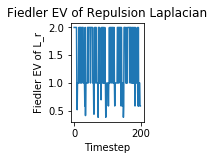

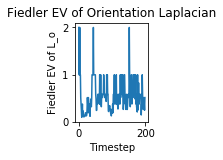

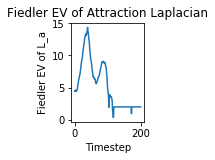

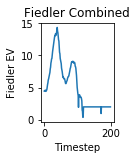

In [6]:
plot_evs(fiedler_r, fiedler_o, fiedler_a, avg_deg_r, avg_deg_o, avg_deg_a, fiedler_COMBINED)

<IPython.core.display.Javascript object>


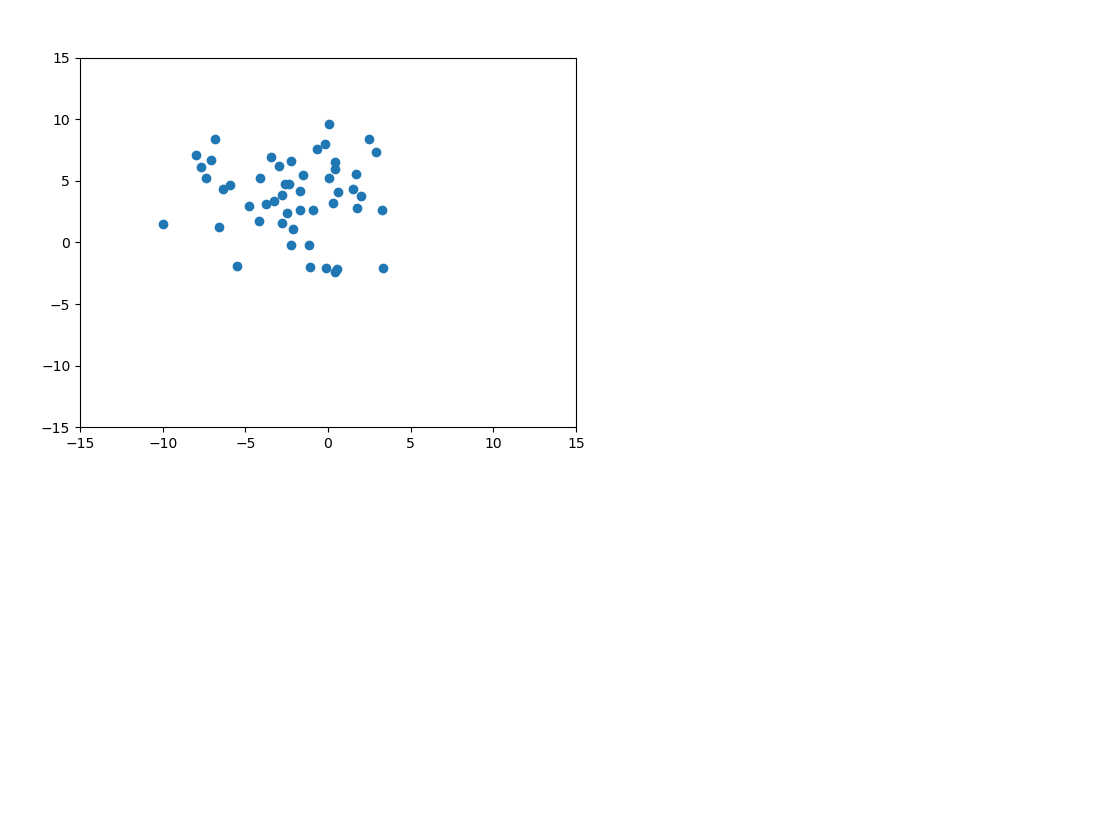

Done


In [7]:
## Swarm

%matplotlib notebook
n_agents = 50
world_dim = 30
M = world_dim / 4
n_neighbors = 5
metric = "dist" # "dist","nn"
n_timesteps = 200
turning_rate = (50 / 360.0) * 2 * math.pi # 100 degrees to radians. Is tune-able
turning_rate = 5/9*math.pi
fop = (225 / 360.0) * 2 * math.pi # 270 degrees field of perception
fop = math.pi*1.5
velocity = 3
tau = 0.1
r_r = 1
r_o = r_r * 1.1
r_a = r_r * 12

plot(n_agents, world_dim, M,n_neighbors,metric,n_timesteps,turning_rate, fop, velocity,tau, r_r,r_o,r_a, contrived=False, arrows=False, force_torus=False, wrap_around=False)

C:\Users\Taylor\AppData\Local\conda\conda\envs\Team\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


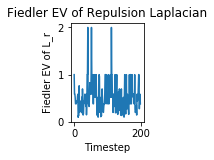

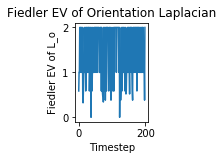

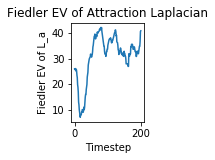

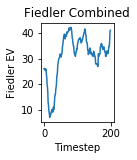

In [8]:
plot_evs(fiedler_r, fiedler_o, fiedler_a, avg_deg_r, avg_deg_o, avg_deg_a, fiedler_COMBINED)

<IPython.core.display.Javascript object>


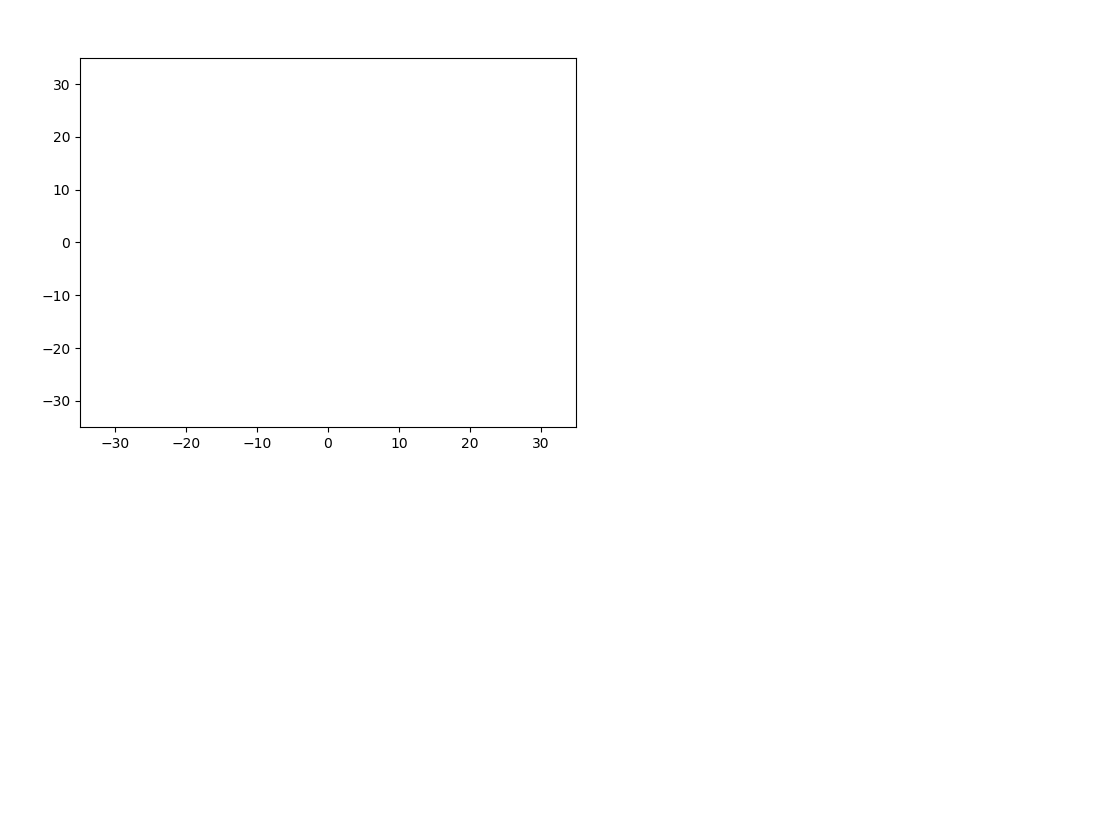

Done


In [9]:
## Dynamic Parallel

%matplotlib notebook
n_agents = 30
world_dim = 70
M = world_dim / 4
n_neighbors = 5
metric = "dist" # "dist","nn"
n_timesteps = 200
turning_rate = (50 / 360.0) * 2 * math.pi # 100 degrees to radians. Is tune-able
turning_rate = 3/9*math.pi
fop = (225 / 360.0) * 2 * math.pi # 270 degrees field of perception
fop = math.pi*1.5
velocity = 1
tau = 0.4
r_r = 2
r_o = r_r * 7
r_a = r_r * 10

plot(n_agents, world_dim, M,n_neighbors,metric,n_timesteps,turning_rate, fop, velocity,tau, r_r,r_o,r_a, contrived=False, arrows=True, force_torus=False, wrap_around=False)

C:\Users\Taylor\AppData\Local\conda\conda\envs\Team\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


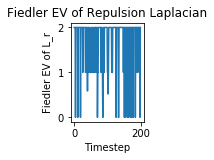

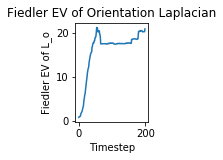

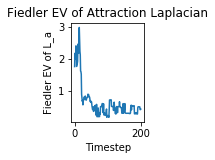

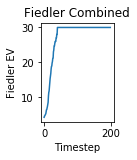

In [10]:
plot_evs(fiedler_r, fiedler_o, fiedler_a, avg_deg_r, avg_deg_o, avg_deg_a, fiedler_COMBINED)

<IPython.core.display.Javascript object>


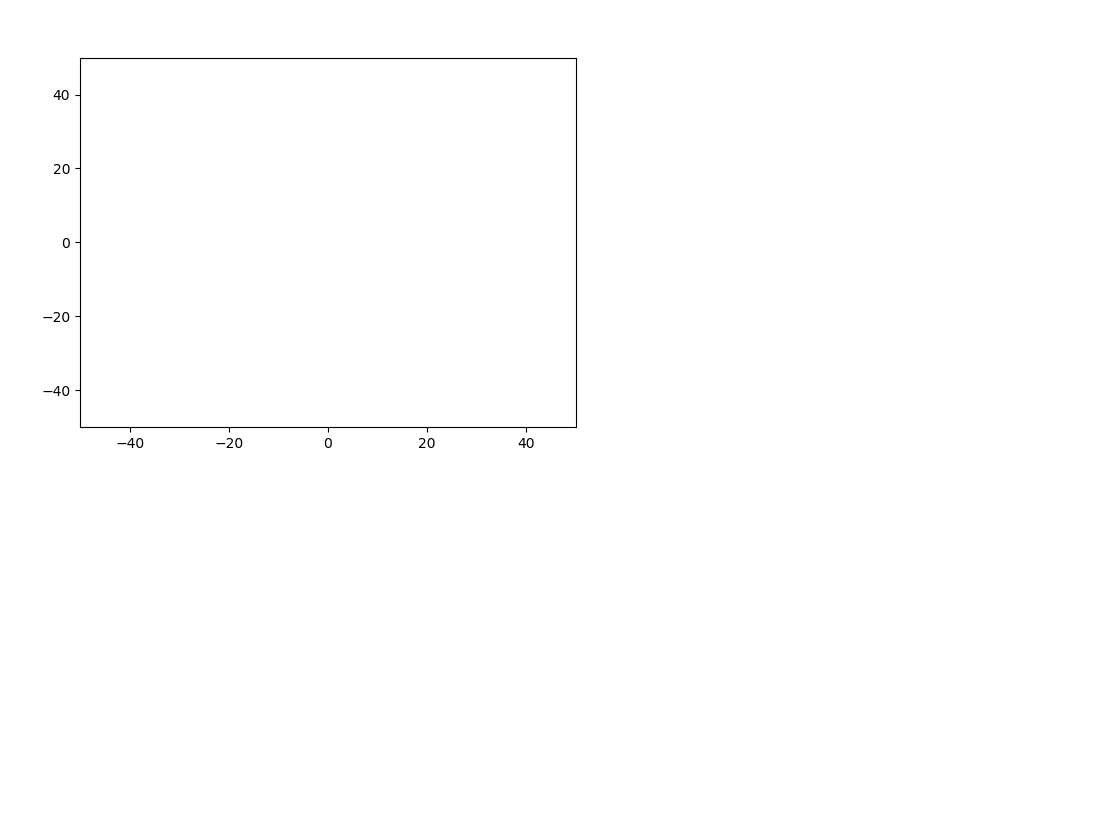

Done


In [11]:
## Strong Parallel

%matplotlib notebook
n_agents = 50
world_dim = 100
M = world_dim / 4
n_neighbors = 5
metric = "dist" # "dist","nn"
n_timesteps = 200
turning_rate = (50 / 360.0) * 2 * math.pi # 100 degrees to radians. Is tune-able
turning_rate = 4/9*math.pi
fop = (225 / 360.0) * 2 * math.pi # 270 degrees field of perception
fop = math.pi*1.2
velocity = 3
tau = 0.3
r_r = 1
r_o = r_r * 12
r_a = r_r * 15
sigma = 0
plot(n_agents, world_dim, M,n_neighbors,metric,n_timesteps,turning_rate, fop, velocity,tau, r_r,r_o,r_a, contrived=False, arrows=True, force_torus=False, sigma=sigma, wrap_around=False)

C:\Users\Taylor\AppData\Local\conda\conda\envs\Team\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


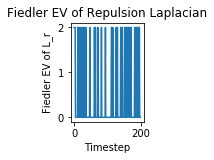

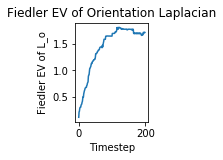

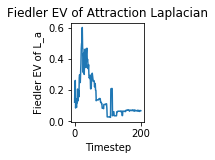

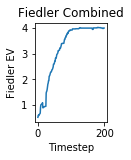

In [12]:
plot_evs(fiedler_r, fiedler_o, fiedler_a, avg_deg_r, avg_deg_o, avg_deg_a, fiedler_COMBINED)

In [13]:
mtx = np.zeros([6,6])

def add_repulsion(mtx, idx, idx2):
    mtx[idx,idx]+=1
    mtx[idx2,idx2]+=1
    mtx[idx,idx2]-=1
    mtx[idx2,idx]-=1
    return mtx
mtx = add_repulsion(mtx,2,3)
mtx = add_repulsion(mtx,1,3)
mtx = add_repulsion(mtx,1,4)
#mtx = add_repulsion(mtx,3,4)
#print(mtx)
get_fiedler_ev(mtx)


0.5857864376269049